In [1]:
# https://wckdouglas.github.io/2020/07/experiment-with-jax

In [ ]:
# https://www.youtube.com/watch?v=z-WSrQDXkuM

In [2]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

In [83]:
class DataGen(object):
    def __init__(self, seed=1):
        self.rng = np.random.RandomState(seed)
    
    def batch(self, xs, batch_size):
        n_samples = len(xs)
        idx = np.arange(n_samples)
        idx = np.random.choice(idx, batch_size, replace=False)
        yield idx

In [84]:
X = np.arange(10)

In [85]:
DG = DataGen()

In [91]:
for e in range(10):
    for i in DG.batch(X, batch_size=5):
        print(i)

[5 6 3 0 7]
[5 9 8 7 4]
[5 4 0 6 1]
[5 7 3 6 2]
[7 9 4 0 8]
[9 4 1 7 8]
[1 7 9 3 6]
[7 4 5 8 9]
[9 8 0 2 6]
[9 5 3 6 8]


In [94]:
for e in range(10):
    batches = DG.batch(X, batch_size=5)
    i = next(batches)
    print(i)

[2 3 0 7 5]
[9 2 1 5 4]
[7 2 8 3 5]
[5 8 9 1 3]
[5 4 9 8 1]
[1 5 4 9 3]
[7 5 8 9 6]
[2 0 6 7 5]
[5 3 0 8 7]
[1 0 6 5 9]


In [90]:
X[next(DG.batch(X, 5))].mean()

5.4

In [ ]:
# loss function

In [104]:
@jax.jit
def loss_function(params, x, y):
    """
    params: list of length 2. first is weight and second is bias
     i.e. linear and constant
    """
    yhat = x.dot(params[0]) + params[1]
    diff = y - yhat
    diff_sq = diff**2
    mse = diff_sq.mean()
    return mse

In [105]:
class SGD(object):
    def __init__(self, lr=1e-3, n_epoch=1000):
        self.lr = lr
        self.n_epoch = n_epoch
        self.losses = np.zeros(n_epoch)
        self.coef_ = None
        self.intercept_ = None
        self.gradients = None
        self._iter = 0
        
    def fit(self, X, y, batch_size):
        self.__InitParams__(X)
        DG = DataGen()
        loss_grad = jax.grad(loss_function)
        for i in range(self.n_epoch):
            minibatch_gen = DG.batch(X, batch_size)
            self._iter += 1
            train_idx = next(minibatch_gen)
            X_train, y_train = X[train_idx], y[train_idx]
            loss = loss_function([self.coef_, self.intercept_], X_train, y_train)
            self.losses[i] = loss
            self.gradients = loss_grad([self.coef_, self.intercept_], X_train, y_train)
            self.__update__()
            if self._iter % (self.n_epoch//10) == 0:
                print(f"{i} epoch - Loss: {loss:.2f}")
                
    def predict(self, X):
        return X.dot(self.coef_) + self.intercept_
    
    def __InitParams__(self, X):
        self.coef_ = np.random.randn(X.shape[1])
        self.intercept_ = np.random.randn(1)
        self._iter = 0
        
    def __update__(self):
        self.coef_ -= self.gradients[0] * self.lr
        self.intercept_ -= self.gradients[1] * self.lr
            
            
            

In [106]:
X = 10 * np.random.random((1000,2))
y = X.dot([3,4]) + np.random.random(1000) + 5


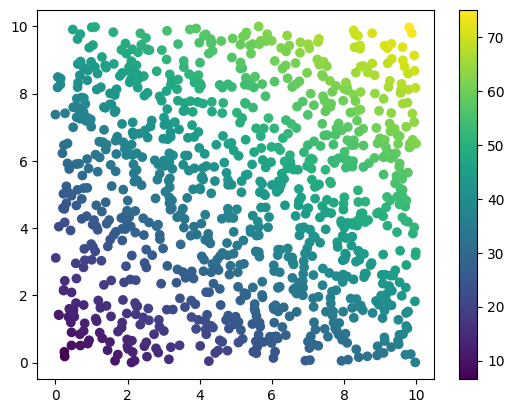

In [121]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.colorbar()

In [107]:
lm = SGD(lr=1e-3, n_epoch=1000)

In [108]:
lm.fit(X, y, 512)

99 epoch - Loss: 3.47
199 epoch - Loss: 3.15
299 epoch - Loss: 2.90
399 epoch - Loss: 2.65
499 epoch - Loss: 2.56
599 epoch - Loss: 2.67
699 epoch - Loss: 2.31
799 epoch - Loss: 2.07
899 epoch - Loss: 2.08
999 epoch - Loss: 1.99


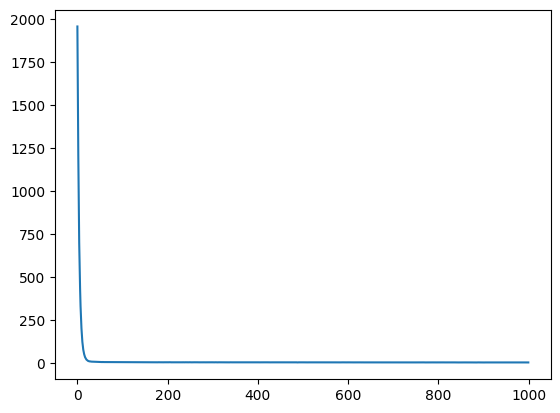

In [110]:
plt.plot(lm.losses)


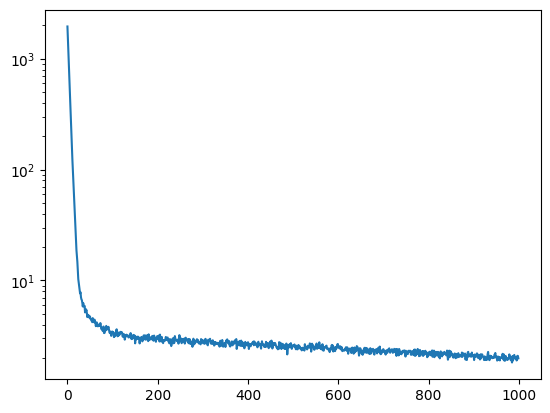

In [111]:
plt.plot(lm.losses)
plt.yscale('log')

In [112]:
lm.coef_

Array([3.3255515, 4.3285623], dtype=float32)

In [113]:
lm.intercept_

Array([1.6672282], dtype=float32)

In [116]:
yhat = lm.predict(X)

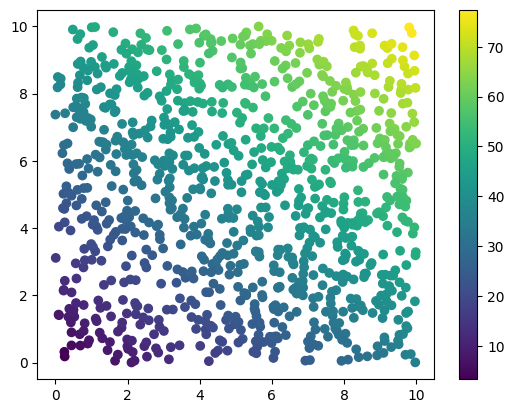

In [120]:
plt.scatter(X[:,0], X[:,1], c=yhat)
plt.colorbar()

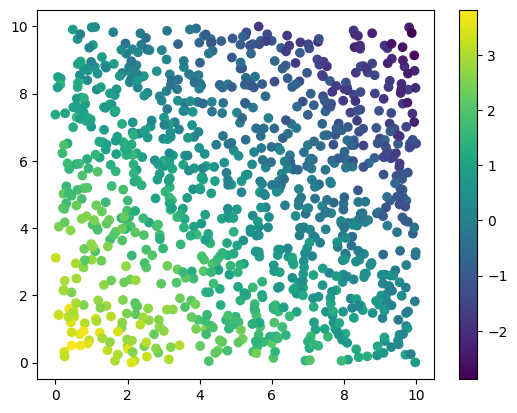

In [119]:
plt.scatter(X[:,0], X[:,1], c=y-yhat)
plt.colorbar()

Text(10, 50, '$R^2$ = 0.9897')

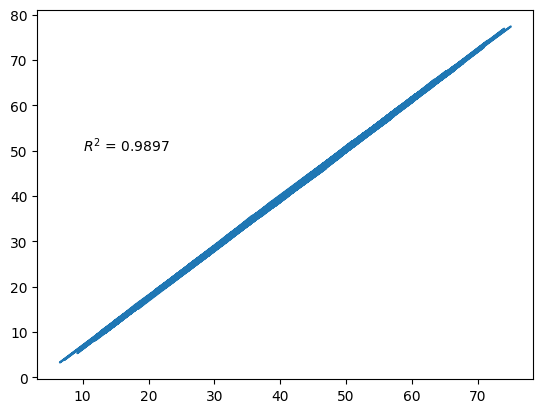

In [122]:
from sklearn.metrics import r2_score
plt.plot(y, lm.predict(X))
plt.text(10,50, '$R^2$ = %.4f' %r2_score(y, lm.predict(X)))

# using optim?

In [ ]:
# https://optax.readthedocs.io/en/latest/optax-101.html

In [123]:
import optax

In [ ]:
# parameterised model from scratch

In [288]:
initial_params = {
    'hidden': jax.random.normal(shape=[2,32], key=jax.random.PRNGKey(0)),
    'output': jax.random.normal(shape=[32,1], key=jax.random.PRNGKey(1)),
    # 'hidden': jax.random.normal(shape=[2,1], key=jax.random.PRNGKey(0)),
    # 'hidden_b': jax.random.normal(shape=[1], key=jax.random.PRNGKey(0)),
}

def net(x: jnp.ndarray, params: jnp.ndarray) -> jnp.ndarray:
    # x = jnp.dot(x, params['hidden']) + params['hidden_b']
    x = jnp.dot(x, params['hidden'])
    x = jax.nn.relu(x)
    x = jnp.dot(x, params['output'])
    return x

In [289]:
diff = (y[:10] - net(X[:10], initial_params))

In [290]:
diff_sq = diff**2

In [291]:
diff_sq.shape

(10, 10)

In [292]:
diff_sq.sum(-1)

Array([3686.9187, 3476.5547, 1396.3795, 1461.3738, 1198.986 , 1287.3127,
       3170.6675, 2828.4058, 2171.6875, 1354.5872], dtype=float32)

In [293]:
diff_sq.mean()

Array(220.32875, dtype=float32)

In [294]:
diff_sq.mean()

Array(220.32875, dtype=float32)

In [295]:
def loss(params: optax.Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    yhat = net(x, params)[:,0] ## needed this for the losses to make sense to me but not sure why...
    loss_value = (y-yhat)**2
    return loss_value.mean()

In [296]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    
    DG = DataGen()
    n_epoch = 100000
    batch_size = 5
    for i in range(n_epoch):
        minibatch_gen = DG.batch(X, batch_size)
        train_idx = next(minibatch_gen)
        X_train, y_train = X[train_idx], y[train_idx]
        params, opt_state, loss_value = step(params, opt_state, X_train, y_train)
        if i % 500 == 0:
            print(f'step {i}, loss: {loss_value}')
            
    return params
        
        
        
        

In [297]:
optimizer = optax.adam(learning_rate=1e-3)
params = fit(initial_params, optimizer)

step 0, loss: 29.455429077148438
step 500, loss: 1.116048812866211
step 1000, loss: 1.8587754964828491
step 1500, loss: 1.6323879957199097
step 2000, loss: 1.4962635040283203
step 2500, loss: 2.081496000289917
step 3000, loss: 5.18025541305542
step 3500, loss: 0.29267337918281555
step 4000, loss: 4.261229991912842
step 4500, loss: 1.7601603269577026
step 5000, loss: 4.292285919189453
step 5500, loss: 2.9073827266693115
step 6000, loss: 0.5441361665725708
step 6500, loss: 4.180492401123047
step 7000, loss: 0.5400552153587341
step 7500, loss: 0.345337837934494
step 8000, loss: 2.9343247413635254
step 8500, loss: 4.473257541656494
step 9000, loss: 1.8393477201461792
step 9500, loss: 0.7383283972740173
step 10000, loss: 3.7660553455352783
step 10500, loss: 7.727050304412842
step 11000, loss: 6.4521989822387695
step 11500, loss: 2.2558133602142334
step 12000, loss: 0.7722660899162292
step 12500, loss: 1.8078752756118774
step 13000, loss: 1.5566083192825317
step 13500, loss: 1.70398330688476

In [298]:
r2_score(y, net(X, params)[:,0])

0.9840043667131538

In [299]:
params

{'hidden': Array([[ 1.11969888e+00, -4.15423332e-04, -5.15412688e-01,
         -3.82354110e-02, -8.98358703e-01,  3.33847338e-03,
         -1.24308860e+00, -1.63114035e+00, -1.57922059e-01,
          1.64496696e+00, -1.38637573e-01, -5.13589799e-01,
          9.78948236e-01, -1.58772618e-01, -4.37541932e-01,
         -1.06883132e+00, -1.39350879e+00,  7.82514155e-01,
         -1.22023694e-01, -9.65026468e-02,  1.19622178e-01,
          1.00083447e+00, -9.78982270e-01, -1.35733593e+00,
          3.04282010e-01, -8.18185568e-01, -1.65979540e+00,
          7.41369784e-01,  3.88731241e-01,  8.79876912e-01,
          4.92279887e-01,  1.69486463e-01],
        [ 3.52528125e-01,  1.12652946e+00,  6.77071810e-01,
          1.49013042e+00, -6.46949708e-01,  6.87851310e-01,
         -8.51833378e-04,  4.01917249e-01, -1.31882823e+00,
         -1.42243719e+00,  5.36983132e-01,  4.17429656e-01,
          5.22920251e-01, -1.65743366e-01, -6.84130609e-01,
          5.37183166e-01,  1.10522461e+00, -6.

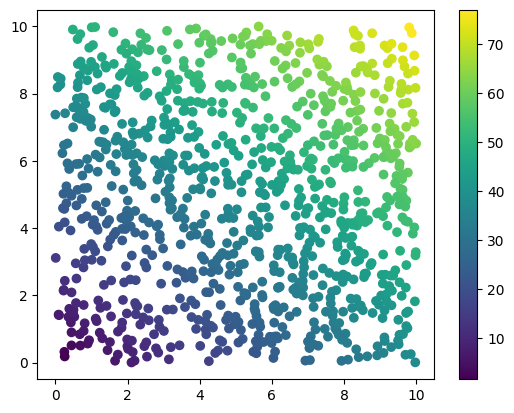

In [300]:
plt.scatter(X[:,0], X[:,1], c=net(X, params)[:,0])
plt.colorbar()

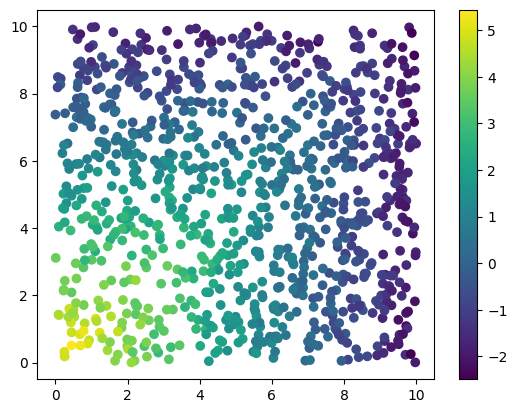

In [301]:
plt.scatter(X[:,0], X[:,1], c=y-net(X, params)[:,0])
plt.colorbar()

In [302]:
params

{'hidden': Array([[ 1.11969888e+00, -4.15423332e-04, -5.15412688e-01,
         -3.82354110e-02, -8.98358703e-01,  3.33847338e-03,
         -1.24308860e+00, -1.63114035e+00, -1.57922059e-01,
          1.64496696e+00, -1.38637573e-01, -5.13589799e-01,
          9.78948236e-01, -1.58772618e-01, -4.37541932e-01,
         -1.06883132e+00, -1.39350879e+00,  7.82514155e-01,
         -1.22023694e-01, -9.65026468e-02,  1.19622178e-01,
          1.00083447e+00, -9.78982270e-01, -1.35733593e+00,
          3.04282010e-01, -8.18185568e-01, -1.65979540e+00,
          7.41369784e-01,  3.88731241e-01,  8.79876912e-01,
          4.92279887e-01,  1.69486463e-01],
        [ 3.52528125e-01,  1.12652946e+00,  6.77071810e-01,
          1.49013042e+00, -6.46949708e-01,  6.87851310e-01,
         -8.51833378e-04,  4.01917249e-01, -1.31882823e+00,
         -1.42243719e+00,  5.36983132e-01,  4.17429656e-01,
          5.22920251e-01, -1.65743366e-01, -6.84130609e-01,
          5.37183166e-01,  1.10522461e+00, -6.